In [2]:
import matplotlib.pyplot as plt

In [3]:
from preprocessing import get_images, prep_size_new_data
import glob
import cv2
import numpy as np

In [ ]:
X_zach = prep_size_new_data(1,2)

In [ ]:
plt.imshow(X_zach[0]);

In [ ]:
from load_and_predict import *

In [ ]:
X = prep_size_new_data(2,3)
cnn_g, cnn_m, cnn_f = load_models()
gender = gender_classifier(X, cnn_g)
am_i_attractive(X, gender, cnn_m, cnn_f)

In [ ]:
cnn_f.predict(X)

In [30]:
def get_and_clean_data(start, n):
    '''
    The number of celeb images: 202599
    The format specification here left pads zeros on the number: 000006
    '''
    celeb_filenames = ['../data/img_align_celeba/{:06d}.jpg'.format(i)
                        for i in range(start + 1, n + 1)]
    full_images = [cv2.imread(f)[...,::-1] for f in celeb_filenames]

    df_labels = pd.read_csv('../data/list_attr_celeba.csv')
    df_labels.columns = map(str.lower, df_labels.columns)
    df_labels.replace([-1], 0, inplace=True)
    return full_images, df_labels[start:n]

def male_female_split(full_images, df):
    '''
    Splits images and df labels to train and testing set based on gender
    Input: 2 int
    Output: Train 2d array / Series
    '''
    full_males = full_images[df[df.male==1].index]
    y_male = df.attractive[df[df.male==1].index]
    full_females = full_images[df[df.male==0].index]
    y_female = df.attractive[df[df.male==0].index]
    Xm_train, Xm_test, ym_train, ym_test = train_test_split(full_males, y_male)
    Xf_train, Xf_test, yf_train, yf_test = train_test_split(full_females, y_female)
    return Xm_train, Xm_test, ym_train, ym_test, Xf_train, Xf_test, yf_train, yf_test

def full_split(full_images, df):
    '''
    Splits images and df labels to train and testing set
    Input: 2 int
    Output: Train 2d array / Series
    '''
    X_train, X_test, y_train, y_test = train_test_split(full_images, df.male)
    return X_train, X_test, y_train, y_test

def get_images(start, n, split=False):
    full_images, df = get_and_clean_data(start,n)
    img = np.asarray(full_images) / 255
    full_images = []
    for i in img:
        full_images.append(cv2.resize(i, dsize=(178, 218)))
    full_images = np.asarray(full_images)
    if split == False:
        return full_split(full_images, df)
    else:
        return male_female_split(full_images, df)

In [31]:
X_train, X_test, y_train, y_test = get_images(0,200)

In [9]:
import pandas as pd 
import numpy as np
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
import tensorflow as tf
from tensorflow.keras import layers
keras = tf.keras
AUTOTUNE = tf.data.experimental.AUTOTUNE
from keras.callbacks import TensorBoard
from livelossplot.keras import PlotLossesCallback
import warnings
warnings.filterwarnings("ignore")

def train_gender_model(X_train, X_test, y_train, y_test):
    print('Training gender model! (might take a while)')
    cnn_g = Sequential()
    input_img = (218, 178, 3)
    batch_size=32
    epochs=15

    # layer 1
    cnn_g.add(Conv2D(2, (3, 3), activation='relu', padding='same', input_shape=input_img))
    cnn_g.add(Conv2D(2, (3, 3), activation='relu', padding='same'))
    cnn_g.add(MaxPooling2D((2, 2), strides=(2,2)))
    # layer 2
    cnn_g.add(Conv2D(4, (3, 3), activation='relu', padding='same'))
    cnn_g.add(Conv2D(4, (3, 3), activation='relu', padding='same'))
    cnn_g.add(MaxPooling2D((2, 2), strides=(2,2)))
    # layer 3
    cnn_g.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    cnn_g.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    cnn_g.add(MaxPooling2D((2, 2), strides=(2,2)))
    # layer 4
    cnn_g.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    cnn_g.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    cnn_g.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    cnn_g.add(MaxPooling2D((2, 2), strides=(2,2)))
    # flatten and add 3 FC layers
    cnn_g.add(Flatten())
    cnn_g.add(Dense(64, activation='relu'))
    cnn_g.add(Dropout(0.5))
    cnn_g.add(Dense(32, activation='relu'))
    cnn_g.add(Dropout(0.5))
    cnn_g.add(Dense(16, activation='relu'))
    cnn_g.add(Dropout(0.5))
    cnn_g.add(Dense(1, activation='sigmoid'))

    cnn_g.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    cnn_g.fit(X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_test, y_test),
            callbacks=[PlotLossesCallback()],
            verbose=0)
    return cnn_g

In [19]:
# Xm_train, Xm_test, ym_train, ym_test, Xf_train, Xf_test, yf_train, yf_test = get_images(0,100, split=True)
X_train, X_test, y_train, y_test = get_images(0,5000)

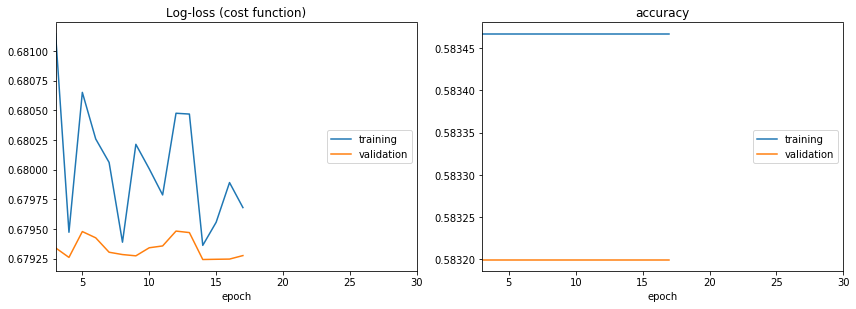

Log-loss (cost function):
training   (min:    0.679, max:    0.686, cur:    0.680)
validation (min:    0.679, max:    0.680, cur:    0.679)

accuracy:
training   (min:    0.581, max:    0.583, cur:    0.583)
validation (min:    0.583, max:    0.583, cur:    0.583)


KeyboardInterrupt: 

In [20]:
cnn_g = train_gender_model(X_train, X_test, y_train, y_test)

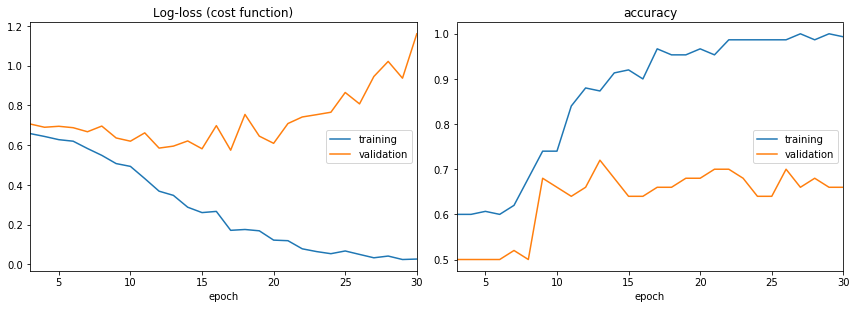

Log-loss (cost function):
training   (min:    0.025, max:    0.690, cur:    0.027)
validation (min:    0.575, max:    1.160, cur:    1.160)

accuracy:
training   (min:    0.507, max:    1.000, cur:    0.993)
validation (min:    0.500, max:    0.720, cur:    0.660)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 218, 178, 2)       56        
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 218, 178, 2)       38        
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 109, 89, 2)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 109, 89, 4)        76        
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 109, 89, 4)      

In [34]:
%%time
cnn_g = Sequential()

input_img = (218, 178, 3)
batch_size=32
epochs=30

# layer 1
cnn_g.add(Conv2D(2, (3, 3), activation='relu', padding='same', input_shape=input_img))
cnn_g.add(Conv2D(2, (3, 3), activation='relu', padding='same'))
cnn_g.add(MaxPooling2D((2, 2), strides=(2,2)))
# layer 2
cnn_g.add(Conv2D(4, (3, 3), activation='relu', padding='same'))
cnn_g.add(Conv2D(4, (3, 3), activation='relu', padding='same'))
cnn_g.add(MaxPooling2D((2, 2), strides=(2,2)))
# # layer 3
# cnn_g.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
# cnn_g.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
# cnn_g.add(MaxPooling2D((2, 2), strides=(2,2)))
# # layer 4
# cnn_g.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
# cnn_g.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
# cnn_g.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
# cnn_g.add(MaxPooling2D((2, 2), strides=(2,2)))
# flatten and add 3 FC layers
cnn_g.add(Flatten())
cnn_g.add(Dense(64, activation='relu'))
cnn_g.add(Dropout(0.5))
# cnn_g.add(Dense(32, activation='relu'))
# cnn_g.add(Dropout(0.5))
# cnn_g.add(Dense(16, activation='relu'))
# cnn_g.add(Dropout(0.5))
cnn_g.add(Dense(1, activation='sigmoid'))

cnn_g.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_g.fit(X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[PlotLossesCallback()],
        verbose=1)

cnn_g.summary()

In [44]:
cnn_g.predict(X_test[:5])

array([[0.00192373],
       [0.03489231],
       [0.00317223],
       [0.00281376],
       [0.35607553]], dtype=float32)

In [51]:
cnn_g.predict_classes(X_test[:10])

array([[0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

In [46]:
y_test

173    0
155    0
175    0
180    1
88     0
71     1
75     1
80     1
29     1
135    1
8      0
94     0
193    1
51     1
11     1
52     1
2      1
72     0
22     1
98     0
56     0
128    1
114    1
40     1
158    0
157    1
171    0
150    0
167    0
129    1
4      0
10     0
23     0
7      1
61     0
3      0
187    1
14     1
185    0
100    0
163    1
141    0
196    1
21     0
152    1
126    1
174    0
20     1
178    0
102    0
Name: male, dtype: int64

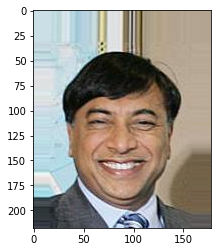

In [49]:
plt.imshow(X_test[5])

In [ ]:
X_train[0]

In [ ]:
plt.imshow(X_train[7])
plt.show()

In [ ]:
y_train